
# Projeto ICMC Júnior
## Objetivo: Prever se um funcionário vai sair da empresa (attrition).

### Etapa final: Modelagem dos dados

In [8]:
import numpy as np
import pandas as pd

In [9]:
# Leitura do dataset (usamos, agora, a base limpa gerada na etapa 1 do projeto)
df = pd.read_csv('dados_limpos.csv')

#### Adequação e preparação final dos dados

In [10]:
# Para preparar os dados para a aplicação de um modelo de Machine Learning, devemos garantir que todos os valores sejam numéricos.
# Assim, convertemos as colunas qualitativas (categóricas) em quantitativas (numéricas).
# Para isso, usamos Label Encoding para colunas binárias e One-Hot Encoding para colunas nominais com mais de duas categorias.

# Função para realizar Label Encoding em colunas qualitativas binárias
def encoding_binary_columns(column, map_values):
    if column not in df.columns:
        print(f"Erro, coluna {column} não encontrada no dataframe")
    
    print(f"Convertendo coluna: '{column}'...")
    print(f"  Valores ANTES: {df[column].unique()}")
    df[column] = df[column].map(map_values) # Aplica mapeamento na coluna
    print(f"  Valores DEPOIS: {df[column].unique()}\n")

encoding_binary_columns('Attrition', {'yes': 1, 'no': 0})
encoding_binary_columns('OverTime', {'yes': 1, 'no': 0})
encoding_binary_columns('Gender', {'female': 1, 'male': 0})

# Lista de colunas do tipo qualitativo nominal
colunas_nominais = [
    'BusinessTravel', 
    'Department', 
    'EducationField', 
    'JobRole', 
    'MaritalStatus'
]
# Realiza a conversão do dados de qualitativo para quantitativo (como consequência, teremos um aumento de colunas de 31 para 45).
df = pd.get_dummies(df, columns=colunas_nominais, dtype = int, drop_first=True) # 'drop_first=True' evita multicolinearidade


Convertendo coluna: 'Attrition'...
  Valores ANTES: ['yes' 'no']
  Valores DEPOIS: [1 0]

Convertendo coluna: 'OverTime'...
  Valores ANTES: ['yes' 'no']
  Valores DEPOIS: [1 0]

Convertendo coluna: 'Gender'...
  Valores ANTES: ['female' 'male']
  Valores DEPOIS: [1 0]



In [11]:
# Com os dados preparados, é feita uma divisão de treino e teste.
from sklearn.model_selection import train_test_split

# Definição da variável alvo (target) e das variáveis preditoras (features)
X = df.drop('Attrition', axis=1) # Variáveis preditoras (todas colunas menos 'Attrition')
y = df['Attrition'] # Variável alvo
print(f"Dimensão das variáveis preditoras (X): {X.shape}")
print(f"Dimensão da variável alvo (y): {y.shape}\n")

# Divisão dos dados em conjuntos de treino e teste (75% treino, 25% teste)
# 'random_state=42' garante reprodutibilidade dos resultados; 'stratify=y' mantém a proporção original das classes na divisão
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Tamanho do conjunto de treino: {X_treino.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_teste.shape[0]} amostras\n")


Dimensão das variáveis preditoras (X): (1470, 44)
Dimensão da variável alvo (y): (1470,)

Tamanho do conjunto de treino: 1102 amostras
Tamanho do conjunto de teste: 368 amostras



In [12]:
# Tendo dividido os dados, aplica-se uma padronização sobre os valores (nem todos os modelos de ML exigem isso, mas é uma boa prática).
# Nisso, a média de todos os valores se torna 0 e o desvio padrão, 1.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Ajusta o scaler apenas com os dados de treino para evitar vazamento de dados (data leakage)
scaler.fit(X_treino)
# Aplica a padronização nos conjuntos de treino e teste
X_treino_padronizado = scaler.transform(X_treino)
X_teste_padronizado = scaler.transform(X_teste)
print(f"\nMédia da primeira coluna de X_treino_padronizado (deve ser ~0): {X_treino_padronizado[:, 0].mean()}")
print(f"\nDesvio Padrão da primeira coluna de X_treino_padronizado (deve ser ~1): {X_treino_padronizado[:, 0].std()}")





Média da primeira coluna de X_treino_padronizado (deve ser ~0): -1.6119390557171058e-17

Desvio Padrão da primeira coluna de X_treino_padronizado (deve ser ~1): 1.0


#### Aplicação dos modelos de Regressão Logísticas e Random Forest

Iniciando busca pelos melhores hiperparâmetros (Grid Search) para Random Forest...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Melhores parâmetros encontrados: {'C': 10, 'solver': 'liblinear'}
Treinando o modelo de Regressão Logística Otimizado...
Treinamento concluído!

Ajustando o limiar de decisão para: 0.3

Avaliação do modelo nos dados de teste---

Acurácia (Accuracy): 69.02%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.67      0.78       309
           1       0.32      0.80      0.45        59

    accuracy                           0.69       368
   macro avg       0.63      0.73      0.62       368
weighted avg       0.84      0.69      0.73       368


Matriz de Confusão:


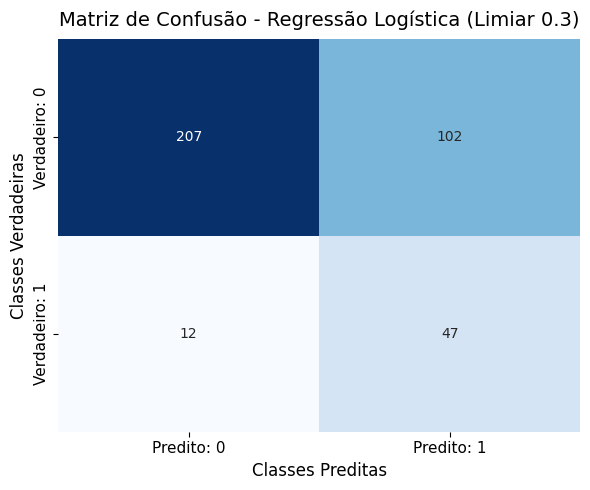

In [13]:
# Por fim, com todos os dados preparados e separados devidamente, podemos aplicar o modelo.
# Escolhemos a Regressão Logística, resumidamente, por ser um modelo simples, eficiente e interpretável.
# Não apenas foi adotado o modelo, mas também foi realizada uma busca em grade (Grid Search) para otimizar seus hiperparâmetros
# e personalizou-se o limiar de decisão para melhorar seu desempenho, com foco na métrica recall para '1'.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cria um objeto do modelo. 'random_state=42' garante reprodutibilidade dos resultados.
rl_modelo = LogisticRegression(random_state=42, class_weight='balanced')

# Realiza uma busca em grade (Grid Search)
# Essa é uma estratégia que testa várias combinações de parâmetros para otimizar o desempenho do modelo
print("Iniciando busca pelos melhores hiperparâmetros (Grid Search) para Random Forest...")
param_grid_rl = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Testando diferentes forças de regularização
    'solver': ['liblinear']          # Solver robusto para datasets menores
}
# 'scoring' define a métrica usada para avaliar o desempenho durante a busca (aqui, f1-score para que haja equilíbrio entre precisão e recall)
# Obs.: apesar de, aqui, ser priorizado o f1-score, a escolha do limiar de decisão posterior visa aumentar o recall, mesmo que isso reduza a precisão
grid_search_rl = GridSearchCV(rl_modelo, param_grid_rl, cv=5, scoring='f1', verbose=1)
grid_search_rl.fit(X_treino_padronizado, y_treino)

# Exibe os melhores parâmetros encontrados pela busca em grade
print(f"\nMelhores parâmetros encontrados: {grid_search_rl.best_params_}")
# Atualiza o modelo com os melhores parâmetros encontrados
rl_modelo = grid_search_rl.best_estimator_

# Treina o modelo com os dados de treino padronizados
print("Treinando o modelo de Regressão Logística Otimizado...")
rl_modelo.fit(X_treino_padronizado, y_treino) # Uso dos dados padronizados de treino
print("Treinamento concluído!")

# Ajusta limiar de decisão (a chance mínima para classificar como positivo)
# O valor padrão é 0.5, mas, após vários treinamentos e avaliações, notou-se que 0.3 oferece um aumento expressivo em 'recall'
# apesar do valor menor de 'precision', o que é aceitável nesse contexto (identificar funcionários propensos a deixar a empresa)
LIMIAR_RL = 0.3
print(f"\nAjustando o limiar de decisão para: {LIMIAR_RL}")

print("\nAvaliação do modelo nos dados de teste---")
# Cria previsões usando o modelo treinado aplicando o limiar definido
y_prob_rl = rl_modelo.predict_proba(X_teste_padronizado)[:, 1] # Probabilidades da classe positiva (1)
y_previsoes_rl = (y_prob_rl >= LIMIAR_RL).astype(int) # Aplica o limiar para obter previsões binárias

# Avaliação das previsões (comparar y_previsoes com y_teste)
print(f"\nAcurácia (Accuracy): {accuracy_score(y_teste, y_previsoes_rl) * 100:.2f}%")

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_previsoes_rl))

# Matriz de confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_teste, y_previsoes_rl)
labels = rl_modelo.classes_

# Exibição da matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predito: 0", "Predito: 1"],
            yticklabels=["Verdadeiro: 0", "Verdadeiro: 1"])

plt.title("Matriz de Confusão - Regressão Logística (Limiar 0.3)", fontsize=14, pad=10)
plt.xlabel("Classes Preditas", fontsize=12)
plt.ylabel("Classes Verdadeiras", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

Iniciando busca pelos melhores hiperparâmetros (Grid Search) para Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits



Melhores parâmetros encontrados: {'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 100}
Treinando o modelo Random Forest Otimizado...
Treinamento concluído!

Ajustando o limiar de decisão para: 0.35

Avaliação do modelo nos dados de teste---

Acurácia (Accuracy): 64.13%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.60      0.74       309
           1       0.29      0.85      0.43        59

    accuracy                           0.64       368
   macro avg       0.62      0.72      0.58       368
weighted avg       0.85      0.64      0.69       368


Matriz de Confusão:


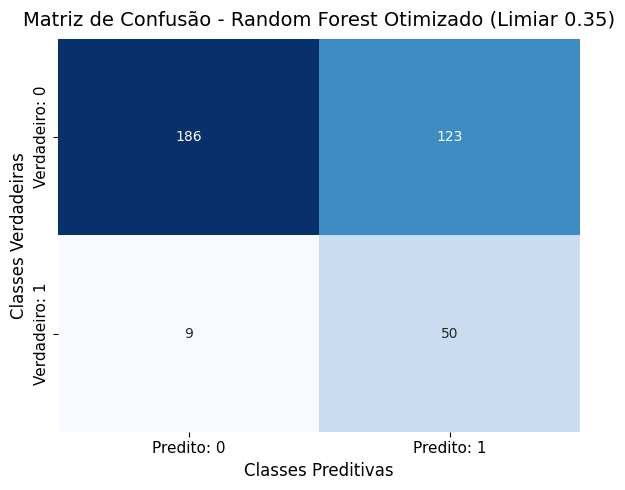

In [14]:
# Com os dados resultantes da Regressão Logística, é possível tentar um modelo mais complexo: Random Forest.
# Assim como na Regressão Logística, aplicamos Grid Search para otimização de hiperparâmetros e ajuste fino do limiar de decisão.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Cria o objeto base do modelo Random Forest.
# Mantém class_weight='balanced' para lidar com o desbalanceamento desde o início.
rf_modelo = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define a grade de parâmetros para o Grid Search.
# São testados diferentes números de árvores, profundidades e regras de folhas para controlar overfitting.
param_grid_rf = {
    'n_estimators': [100, 200],       # Quantidade de árvores na floresta
    'max_depth': [5, 8, 10, None],    # Profundidade máxima de cada árvore
    'min_samples_leaf': [1, 2, 4]     # Mínimo de amostras para criar uma folha final
}

# Configura o Grid Search.
# scoring='recall' força o modelo a priorizar a captura da classe minoritária (1).
# n_jobs=-1 usa todos os núcleos do processador para acelerar o treinamento.
print("Iniciando busca pelos melhores hiperparâmetros (Grid Search) para Random Forest...")
grid_search_rf = GridSearchCV(rf_modelo, param_grid_rf, cv=5, scoring='recall', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_treino, y_treino) # Obs.: RF não usa dados padronizados

# Exibe e seleciona o melhor modelo encontrado
print(f"\nMelhores parâmetros encontrados: {grid_search_rf.best_params_}")
rf_modelo = grid_search_rf.best_estimator_

# Treina o modelo otimizado (redundante, pois o GridSearch já o treinou, mas bom para clareza)
print("Treinando o modelo Random Forest Otimizado...")
rf_modelo.fit(X_treino, y_treino)
print("Treinamento concluído!")

# Ajuste de limiar de decisão.
# Para Random Forest, o padrão também é 0.5. Foi optado um valor de 0.35 para aumentar o recall.
LIMIAR_RF = 0.35
print(f"\nAjustando o limiar de decisão para: {LIMIAR_RF}")

print("\nAvaliação do modelo nos dados de teste---")
# Obtém as probabilidades da classe positiva (1)
y_prob_rf = rf_modelo.predict_proba(X_teste)[:, 1]
# Aplica o limiar personalizado
y_previsoes_rf = (y_prob_rf >= LIMIAR_RF).astype(int)

# Avaliação das previsões
print(f"\nAcurácia (Accuracy): {accuracy_score(y_teste, y_previsoes_rf) * 100:.2f}%")

print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_previsoes_rf))

print("\nMatriz de Confusão:")
cm1 = confusion_matrix(y_teste, y_previsoes_rf)

# Exibição da matriz de confusão 
plt.figure(figsize=(6,5))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predito: 0", "Predito: 1"],
            yticklabels=["Verdadeiro: 0", "Verdadeiro: 1"])
plt.title("Matriz de Confusão - Random Forest Otimizado (Limiar 0.35)", fontsize = 14, pad=10)
plt.xlabel("Classes Preditivas", fontsize=12)
plt.ylabel("Classes Verdadeiras", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()